# Multiple Linear Regression from Scratch

### Step 1: Data Preprocessing & Split

In this step, we will load the `concrete_data.csv` dataset, split it into features (X) and target (y), and then split it into training and testing sets. We will also normalize the features.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('concrete_data.csv')
X = df.iloc[:, :-1].values # Features
y = df.iloc[:, -1].values # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (824, 8)
Test data shape: (206, 8)


### Step 2: Model Training

Here, we initialize the model parameters (theta and bias) and train the model using gradient descent.

In [11]:
import numpy as np

np.random.seed(42)
theta = np.random.randn(X_train.shape[1], 1)
bias = 0.0
learning_rate = 0.01
iterations = 1000
losses = []

for i in range(iterations):
    y_pred = np.dot(X_train, theta) + bias
    error = y_pred - y_train.reshape(-1, 1)
    loss = np.mean(error**2)
    losses.append(loss)
    
    grad_theta = (2/len(X_train)) * np.dot(X_train.T, error)
    grad_bias = (2/len(X_train)) * np.sum(error)
    
    theta -= learning_rate * grad_theta
    bias -= learning_rate * grad_bias
    
    if (i+1) % 100 == 0:
        print(f'Iteration {i+1}/{iterations}, Loss: {loss:.4f}')

Iteration 100/1000, Loss: 144.8981
Iteration 200/1000, Loss: 116.3074
Iteration 300/1000, Loss: 114.2811
Iteration 400/1000, Loss: 113.3959
Iteration 500/1000, Loss: 112.8582
Iteration 600/1000, Loss: 112.4964
Iteration 700/1000, Loss: 112.2308
Iteration 800/1000, Loss: 112.0219
Iteration 900/1000, Loss: 111.8498
Iteration 1000/1000, Loss: 111.7036


### Step 3: Evaluation

Now, we evaluate the trained model on the test set by calculating the Mean Squared Error (MSE).

In [12]:
y_pred_test = np.dot(X_test, theta) + bias
mse = np.mean((y_pred_test - y_test.reshape(-1, 1))**2)
print(f'Mean Squared Error on Test Set: {mse:.4f}')

Mean Squared Error on Test Set: 96.5267


### Step 4: Visualization

We will now visualize the training process by plotting the loss curve and the predictions vs. actual values.

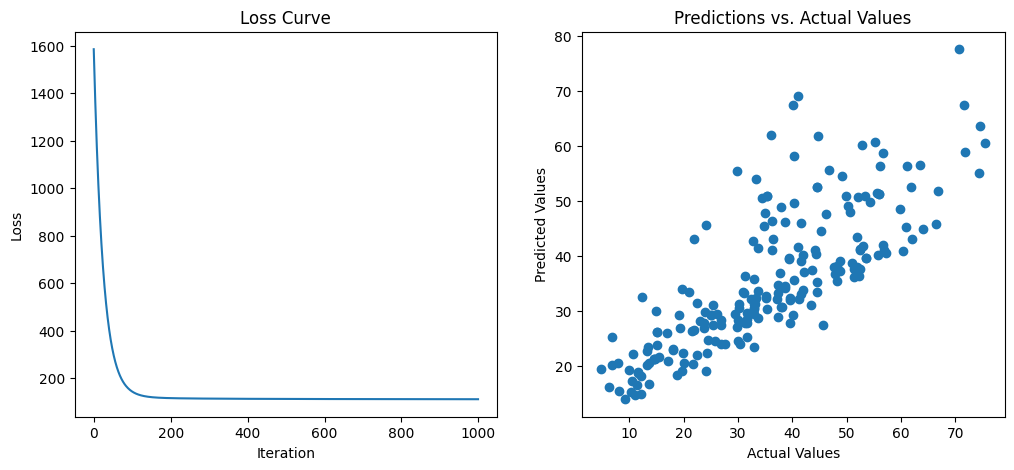

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Predictions vs. Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Actual Values')

plt.show()

### Bonus: Hyper-parameter Tuning

Finally, we will perform hyper-parameter tuning to find the best learning rate for our model.

In [14]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
best_mse = float('inf')
best_lr = None

for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    np.random.seed(42)
    theta = np.random.randn(X_train.shape[1], 1)
    bias = 0.0
    iterations = 1000
    
    for i in range(iterations):
        y_pred = np.dot(X_train, theta) + bias
        error = y_pred - y_train.reshape(-1, 1)
        loss = np.mean(error**2)
        
        grad_theta = (2/len(X_train)) * np.dot(X_train.T, error)
        grad_bias = (2/len(X_train)) * np.sum(error)
        
        theta -= lr * grad_theta
        bias -= lr * grad_bias

    y_pred_test = np.dot(X_test, theta) + bias
    mse = np.mean((y_pred_test - y_test.reshape(-1, 1))**2)
    print(f'MSE on Test Set: {mse:.4f}')
    
    if mse < best_mse:
        best_mse = mse
        best_lr = lr

print(f'Best learning rate: {best_lr} with MSE: {best_mse:.4f}')

Training with learning rate: 0.1
MSE on Test Set: 95.9697
Training with learning rate: 0.05
MSE on Test Set: 95.9471
Training with learning rate: 0.01
MSE on Test Set: 96.5267
Training with learning rate: 0.005
MSE on Test Set: 97.9148
Training with learning rate: 0.001
MSE on Test Set: 130.6094
Best learning rate: 0.05 with MSE: 95.9471
